<a href="https://colab.research.google.com/github/suriyanrk/Taxi-Mobility-Surge-Price-Prediction/blob/main/Taxi_Mobility_Surge_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Taxi Mobility Surge Price Prediction**

Data provided by an Indian cab aggregator service Sigma Cabs. Their customers can download their app on smartphones and book a cab from anywhere in the cities they operate in. They, in turn, search for cabs from various service providers and provide the best option to their clients across available options. They have been in operation for a little less than a year now. During this period, they have captured surge pricing types from the service providers.
The main objective is to build a predictive model, which could help them in predicting the surge pricing type proactively. This would in turn help them in matching the right cabs with the right customers quickly and efficiently.
* Trip_ID: ID for TRIP
* Trip_Distance: The distance for the trip requested by the customer
* TypeofCab: Category of the cab requested by the customer
* CustomerSinceMonths: Customer using cab services since n months; 0 month means the current month
* LifeStyleIndex: Proprietary index created by Sigma Cabs showing the lifestyle of the customer based on their behaviour
* ConfidenceLifeStyle_Index: Category showing confidence on the index mentioned above
* Destination_Type: Sigma Cabs divides any destination into one of the 14 categories.
* Customer_Rating: Average of lifetime ratings of the customer till date
* CancellationLast1Month: Number of trips cancelled by the customer in last 1 month
* Var1, Var2 and Var3: Continuous variables masked by the company. Can be used for modelling purposes
* Gender: Gender of the customer
* SurgePricingType: Target (can be of 3 types) - DV

#Importing Libraries

In [1]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn import ensemble

import warnings
warnings.filterwarnings('ignore')

#Loading the data set

In [3]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path='/content/drive/MyDrive/Capestone/sigma_cabs.csv'
df=pd.read_csv(path)

#**Exploratory Data Analysis**

###Let's start with doing some exploratory data analysis.

In [5]:
#shape of data
df.shape

(131662, 14)

**Dataset have 131662 records and 14 features**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  111452 non-null  object 
 3   Customer_Since_Months        125742 non-null  float64
 4   Life_Style_Index             111469 non-null  float64
 5   Confidence_Life_Style_Index  111469 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         60632 non-null   float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

In [7]:
df.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [8]:
#Checking for duplicated records
df.duplicated().sum()

0

**There are no duplicated datas**

##We start with the analysis of our dependent variable **Surge_Pricing_Type**

In [9]:
df['Surge_Pricing_Type'].value_counts()

2    56728
3    47720
1    27214
Name: Surge_Pricing_Type, dtype: int64

* **Here we can see that it's a Multiclass classification problem having imbalanced target variables.**

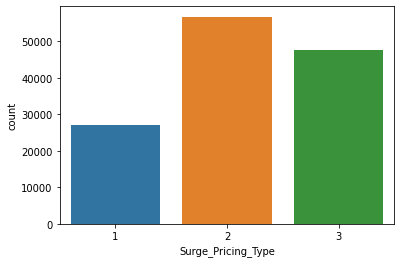

In [10]:
sns.countplot(df['Surge_Pricing_Type'])

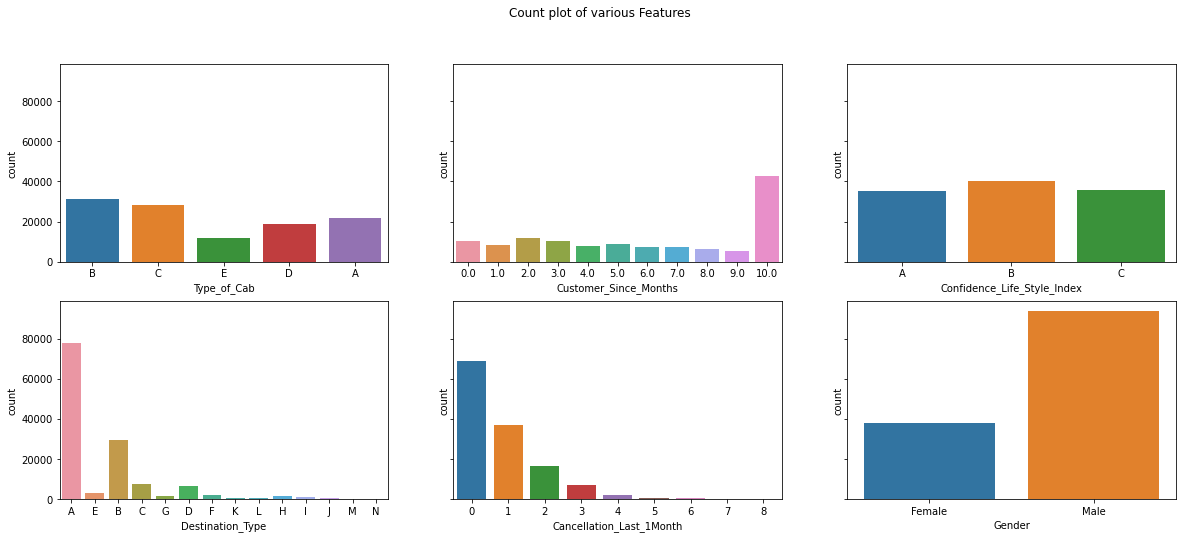

In [11]:
#let's plot countplots of some features
fig,axes=plt.subplots(2,3, figsize=(20,8),sharey=True)
fig.suptitle('Count plot of various Features')
#1
sns.countplot(ax=axes[0,0],x=df['Type_of_Cab'])
#2
sns.countplot(ax=axes[0,1],x=df['Customer_Since_Months'])
#3
sns.countplot(ax=axes[0,2],x=df['Confidence_Life_Style_Index'])
#4
sns.countplot(ax=axes[1,0],x=df['Destination_Type'])
#5
sns.countplot(ax=axes[1,1],x=df['Cancellation_Last_1Month'])
#6
sns.countplot(ax=axes[1,2],x=df['Gender'])

In [12]:
columns=['Type_of_Cab','Customer_Since_Months','Confidence_Life_Style_Index','Destination_Type','Cancellation_Last_1Month','Gender']

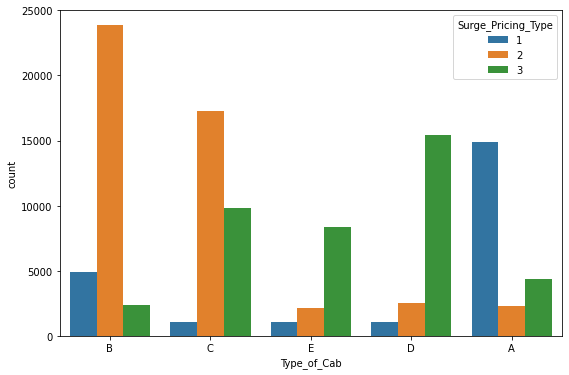

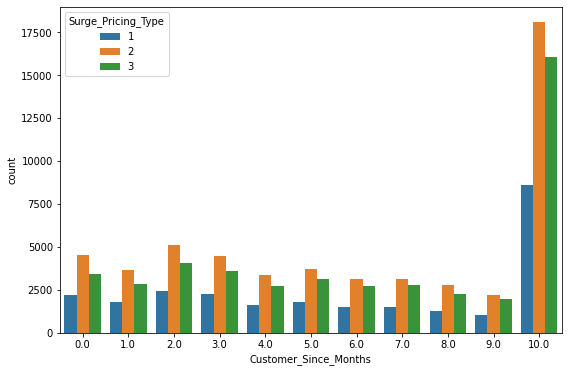

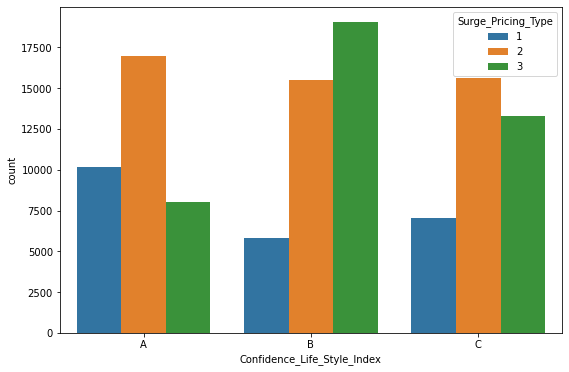

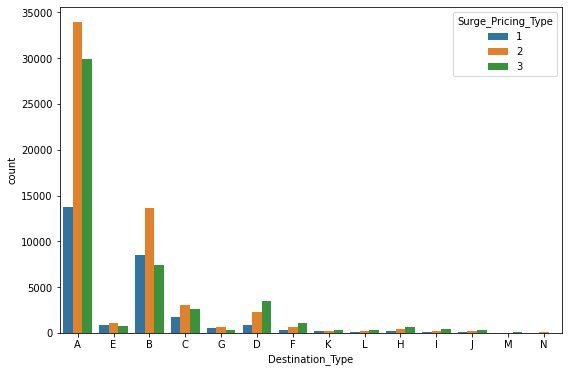

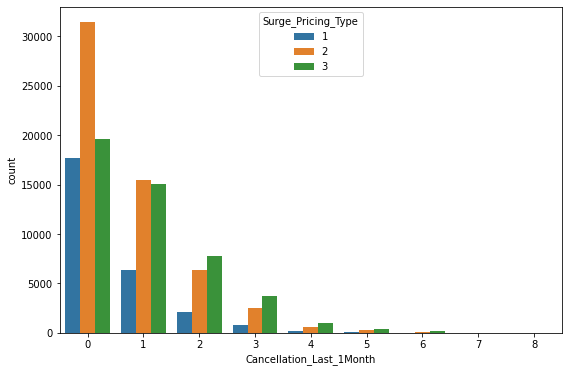

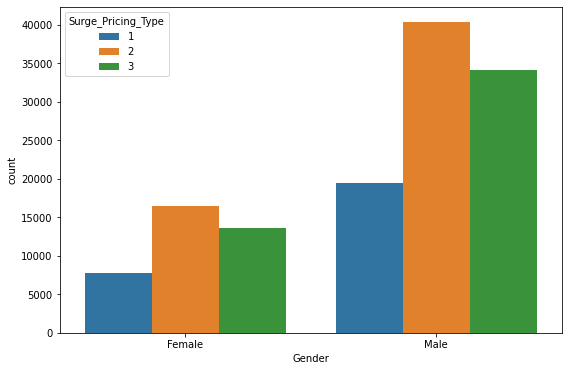

In [13]:
for feature in columns:
  plt.figure(figsize=(9,6))
  sns.countplot(x=feature,data=df,hue=df['Surge_Pricing_Type'])

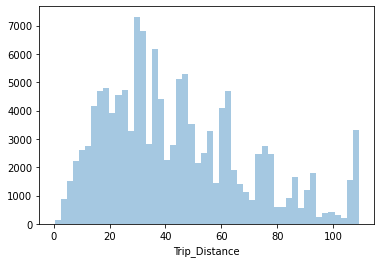

In [14]:
sns.distplot(df['Trip_Distance'],kde = False,norm_hist=False)

###Trip_ID column seems to be of no use for modelling. So we can simply drop it.

In [15]:
df.drop('Trip_ID',axis=1,inplace=True)

#Cleaning the data
##Handling the null values

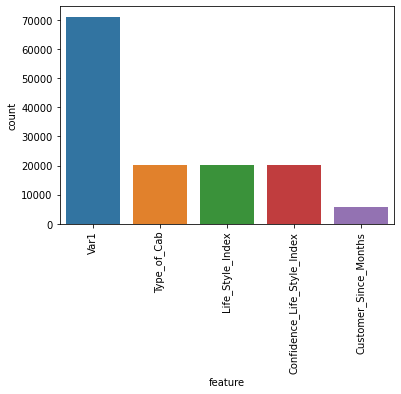

In [16]:
null_df=df.isna().sum().reset_index().rename(columns={'index':'feature',0:'count'})
null_df=null_df[null_df['count']!=0].sort_values('count',ascending=False).reset_index()
g=sns.barplot(x='feature',y='count',data=null_df)
g.set_xticklabels(labels=null_df['feature'], rotation=90)
plt.show()

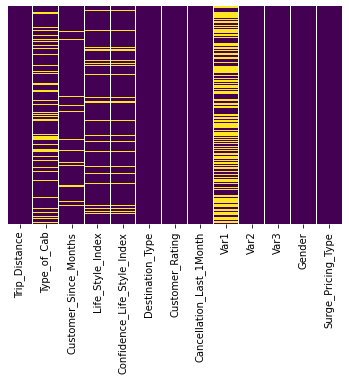

In [17]:
#checking the missing data in the dataset
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.rcParams['figure.figsize'] = (15, 5)

In [18]:
df.isnull().mean()*100

Trip_Distance                   0.000000
Type_of_Cab                    15.349911
Customer_Since_Months           4.496362
Life_Style_Index               15.336999
Confidence_Life_Style_Index    15.336999
Destination_Type                0.000000
Customer_Rating                 0.000000
Cancellation_Last_1Month        0.000000
Var1                           53.948748
Var2                            0.000000
Var3                            0.000000
Gender                          0.000000
Surge_Pricing_Type              0.000000
dtype: float64

###Our dataset contains null values in following columns:
* Type_of_Cab                    
* Customer_Since_Months           
* Life_Style_Index               
* Confidence_Life_Style_Index    
* Var1                           

### We have more than 50 % null values in Var1 column.
###Hence, we can simply drop var1 column

In [19]:
df.drop('Var1',axis=1,inplace=True)

###Handling the other 4 columns having null values

In [20]:
null_df=df.isna().sum().reset_index().rename(columns={'index':'feature',0:'count'})
null_df=null_df[null_df['count']!=0]
null_df['percentage']=null_df['count'].apply(lambda x: (x/len(df)*100))
null_df.sort_values('count',ascending=False)

,feature,count,percentage
1,Type_of_Cab,20210,15.349911
3,Life_Style_Index,20193,15.336999
4,Confidence_Life_Style_Index,20193,15.336999
2,Customer_Since_Months,5920,4.496362


* **Dropping all those rows having null values as it will not make much impact as our dataset is too large.**

In [21]:
#creating a copy of the original df
new_df=df.copy()

In [22]:
df.shape

(131662, 12)

In [23]:
#dropping all those rows having nan values
new_df.dropna(inplace=True)
new_df.shape

(90052, 12)

In [24]:
# df['Type_of_Cab']=df['Type_of_Cab'].fillna(df['Type_of_Cab'].mode()[0])
# df['Customer_Since_Months']=df['Customer_Since_Months'].fillna(round(df['Customer_Since_Months'].mean()))
# df['Life_Style_Index']=df['Life_Style_Index'].fillna(df['Life_Style_Index'].mean())
# df['Confidence_Life_Style_Index']=df['Confidence_Life_Style_Index'].fillna(df['Confidence_Life_Style_Index'].mode()[0])

In [25]:
new_df.isna().sum()

Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64

* **we have no null values in the new_df**



In [26]:
new_df['Surge_Pricing_Type'].value_counts()

2    38918
3    32504
1    18630
Name: Surge_Pricing_Type, dtype: int64

##**Now, let's analyse the numerical features of the dataset.**

In [27]:
new_df.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var2,Var3,Surge_Pricing_Type
count,90052.000000,90052.000000,90052.000000,90052.000000,90052.000000,90052.000000,90052.000000,90052.000000
mean,44.570410,6.009872,2.809990,2.856178,0.786257,51.268834,75.197841,2.154067
std,25.550645,3.627505,0.221479,0.973910,1.041551,4.991620,11.594410,0.737629
min,0.310000,0.000000,1.596380,0.001250,0.000000,40.000000,52.000000,1.000000
25%,24.880000,3.000000,2.661130,2.166250,0.000000,48.000000,67.000000,2.000000
50%,38.450000,6.000000,2.807160,2.903750,0.000000,50.000000,74.000000,2.000000
75%,60.940000,10.000000,2.951590,3.581250,1.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,124.000000,206.000000,3.000000


In [28]:
num_features=['Trip_Distance','Life_Style_Index','Customer_Rating','Var2','Var3']

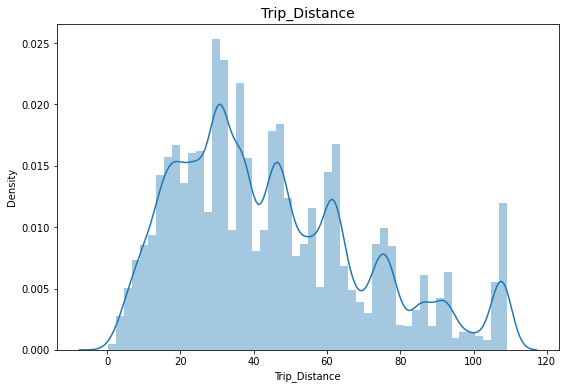

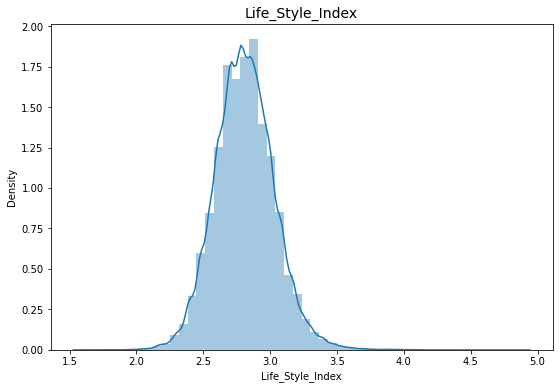

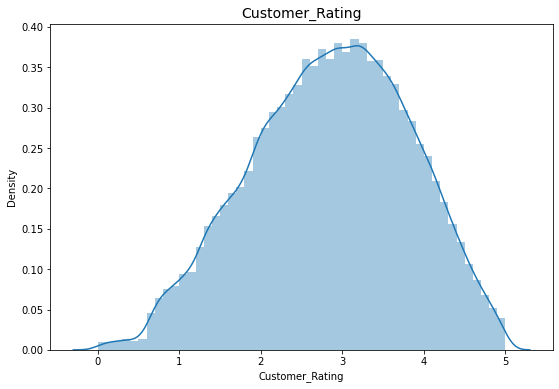

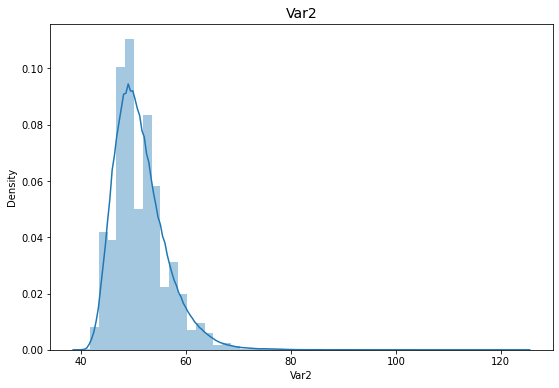

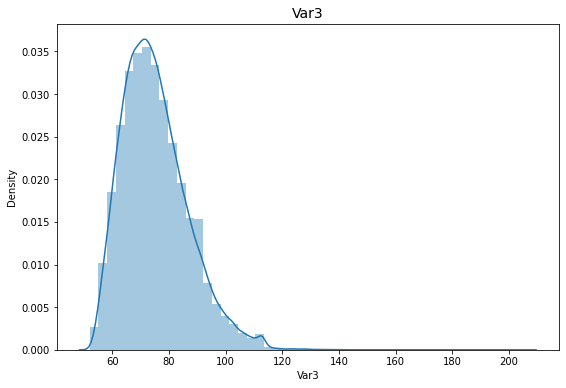

In [29]:
for feature in num_features:
  plt.figure(figsize=(9,6))
  sns.distplot(new_df[feature])
  plt.title(feature,fontsize=14)

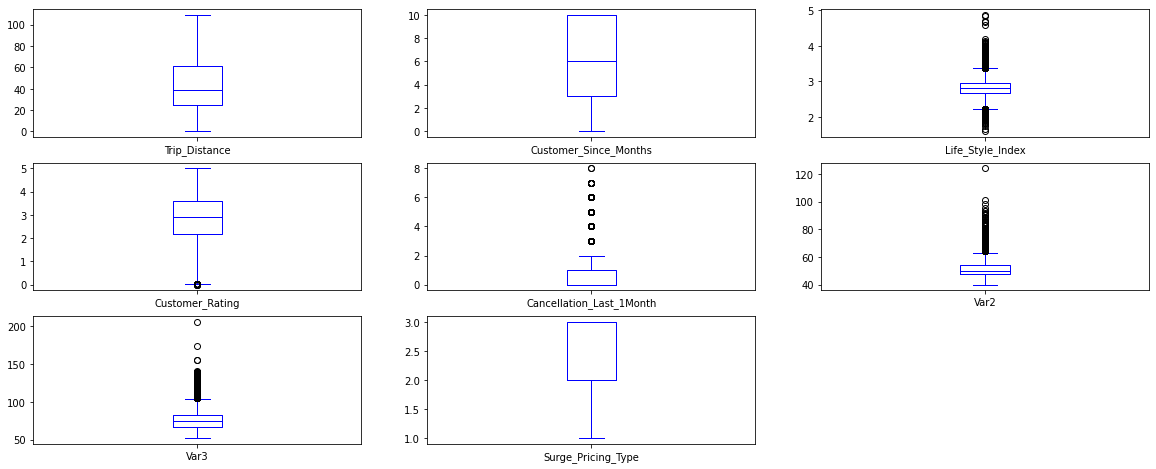

In [30]:
#Boxplot of numerical columns
new_df.plot(kind='box', layout=(3,3),subplots=True,figsize=(20,8),color='b')
plt.show()

In [31]:
#Converting the type of Customer_Since_Months from float to int
new_df['Customer_Since_Months']=new_df['Customer_Since_Months'].astype(int)

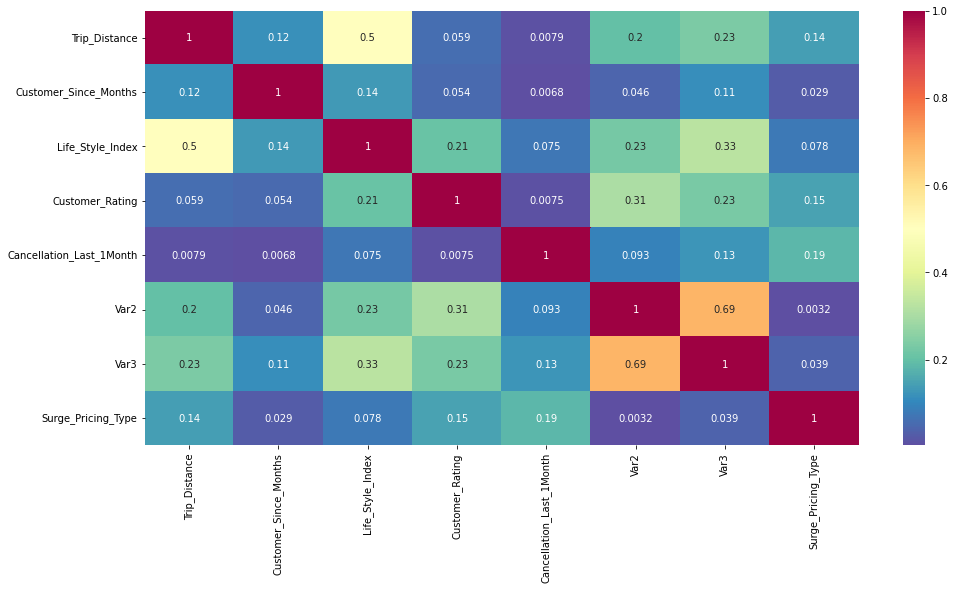

In [32]:
# Lets look at the correlation matrix now.
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
cor=new_df.corr()
sns.heatmap(abs(cor),annot=True, cmap='Spectral_r')

In [33]:
new_df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var2,Var3,Gender,Surge_Pricing_Type
0,6.77,B,1,2.42769,A,A,3.9050,0,46,60,Female,2
1,29.47,B,10,2.78245,B,A,3.4500,0,56,78,Male,2
4,54.95,C,10,3.03453,B,A,3.4025,4,49,102,Male,2
6,29.72,E,10,2.83958,C,B,2.9750,1,50,75,Male,2
7,18.44,B,2,2.81871,B,A,3.5825,0,46,63,Male,2


##**Categorical Columns**
* Type_of_Cab
* Confidence_Life_Style_Index  
* Destination_Type             
* Gender    

In [34]:
fin_df=new_df.copy()

* **Let's deal with Categorical columns**

In [35]:
# Converting Gender column into numerical features
gender_dict={'Female':0,'Male':1}

fin_df['Gender']=fin_df['Gender'].map(gender_dict)

In [36]:
# One hot encoding
fin_df= pd.get_dummies(fin_df, columns=["Type_of_Cab", "Confidence_Life_Style_Index","Destination_Type"], prefix=["cab_type", "confidence_index","destination_type"],drop_first=True)

In [37]:
fin_df.shape

(90052, 28)

In [38]:
fin_df.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var2,Var3,Gender,Surge_Pricing_Type,cab_type_B,...,destination_type_E,destination_type_F,destination_type_G,destination_type_H,destination_type_I,destination_type_J,destination_type_K,destination_type_L,destination_type_M,destination_type_N
0,6.77,1,2.42769,3.9050,0,46,60,0,2,1,...,0,0,0,0,0,0,0,0,0,0
1,29.47,10,2.78245,3.4500,0,56,78,1,2,1,...,0,0,0,0,0,0,0,0,0,0
4,54.95,10,3.03453,3.4025,4,49,102,1,2,0,...,0,0,0,0,0,0,0,0,0,0
6,29.72,10,2.83958,2.9750,1,50,75,1,2,0,...,0,0,0,0,0,0,0,0,0,0
7,18.44,2,2.81871,3.5825,0,46,63,1,2,1,...,0,0,0,0,0,0,0,0,0,0


* **Now, our dataset have 28 features and we are done with categorical features too**

##**Feature Selection**

* **Let's compare the features**

In [39]:
X=fin_df.drop('Surge_Pricing_Type',axis=1)
y=fin_df['Surge_Pricing_Type']

In [40]:
X.shape,y.shape

((90052, 27), (90052,))

In [41]:
# ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
ET=ExtraTreesClassifier()
ET.fit(X,y)
feat_dict={'feature':X.columns,'importance':ET.feature_importances_}
feature_df=pd.DataFrame(feat_dict)

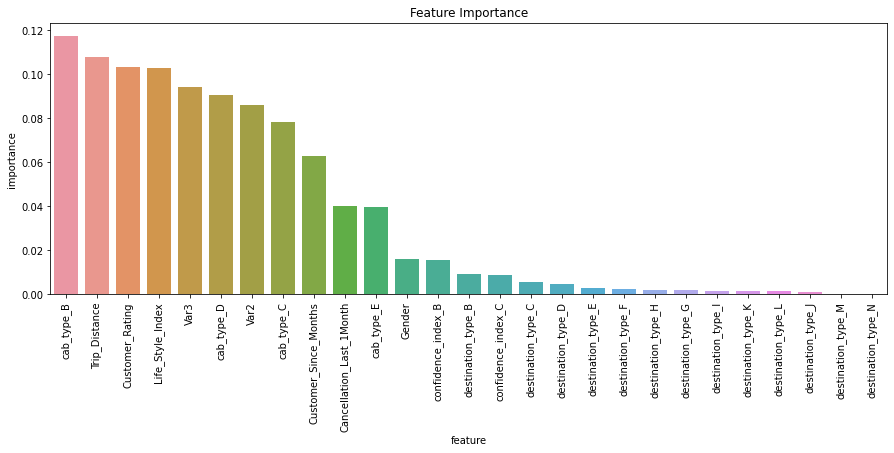

In [42]:
feature_df.sort_values('importance',ascending=False,inplace=True)
g=sns.barplot(x='feature',y='importance',data=feature_df)
g.set_xticklabels(labels=feature_df['feature'], rotation=90)
plt.title('Feature Importance')
plt.show()

* **Now we can apply feature selection here and can drop less important features**

##Feature selection for categorical input that has categorical output: Chi-Squared

H0- Categorical features are independent from the surge pricing category

H1- Categorical features are dependent on the surge pricing category

The significance level remains 5% for this.

In [43]:
fin_df.columns

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var2', 'Var3', 'Gender',
       'Surge_Pricing_Type', 'cab_type_B', 'cab_type_C', 'cab_type_D',
       'cab_type_E', 'confidence_index_B', 'confidence_index_C',
       'destination_type_B', 'destination_type_C', 'destination_type_D',
       'destination_type_E', 'destination_type_F', 'destination_type_G',
       'destination_type_H', 'destination_type_I', 'destination_type_J',
       'destination_type_K', 'destination_type_L', 'destination_type_M',
       'destination_type_N'],
      dtype='object')

In [44]:
dependent_variable= fin_df['Surge_Pricing_Type']

categorical_features=['Cancellation_Last_1Month', 'Gender', 'Surge_Pricing_Type',
       'cab_type_B', 'cab_type_C', 'cab_type_D', 'cab_type_E',
       'confidence_index_B', 'confidence_index_C', 'destination_type_B',
       'destination_type_C', 'destination_type_D', 'destination_type_E',
       'destination_type_F', 'destination_type_G', 'destination_type_H',
       'destination_type_I', 'destination_type_J', 'destination_type_K',
       'destination_type_L', 'destination_type_M', 'destination_type_N']

In [45]:
from sklearn.feature_selection import chi2
#Defining the dependent variable
dependent_variable= fin_df['Surge_Pricing_Type']
cat_df=fin_df[categorical_features]
#Checking the Chi-scores array

chi_scores = chi2(cat_df,dependent_variable)

print(*chi_scores)

[4.36905234e+03 4.13094377e-02 2.27460387e+04 1.24757739e+04
 4.87004575e+03 1.32863060e+04 5.24532842e+03 2.02580837e+03
 3.76378137e+01 1.34049001e+03 3.15790920e+01 5.07458511e+02
 1.20325710e+02 1.97456132e+02 1.56033130e+02 5.68496944e+01
 9.86709681e+01 4.45941173e+01 1.11212377e+01 3.30281828e+01
 6.19917879e+00 2.75409033e+01] [0.00000000e+000 9.79557129e-001 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 6.71510176e-009 8.24694780e-292 1.38895221e-007 6.40891394e-111
 7.44053211e-027 1.32722836e-043 1.31170540e-034 4.52111667e-013
 3.74862083e-022 2.07257597e-010 3.84639540e-003 6.73009568e-008
 4.50677037e-002 1.04608948e-006]


**The first array in this array contains chi-square values and the second contains p-values**

**For our feature selection we should take p-values.**

In [46]:
p_values=pd.Series(chi_scores[1],index=cat_df.columns)
p_values.sort_values(ascending = False , inplace = True)

Text(0.5, 1.0, 'P-values for categorical features')

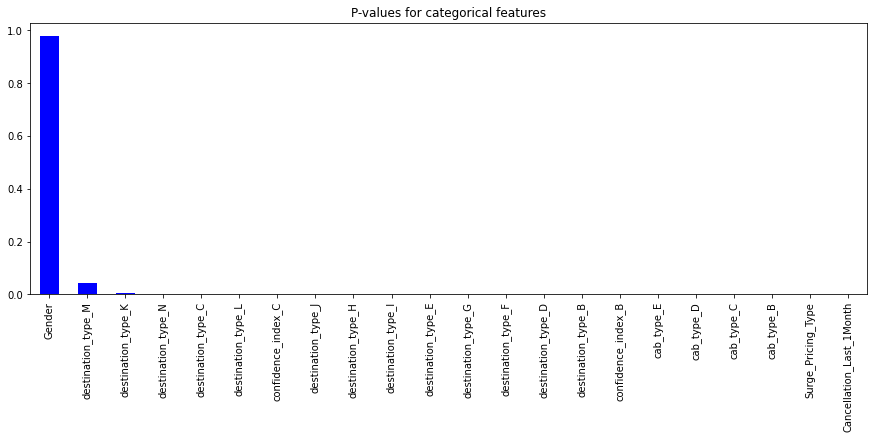

In [47]:
p_values.plot(kind='bar',color='b')

plt.title('P-values for categorical features') 

*** p-value of gender is very high which means that this variable is independent of the surge pricing and therefore should not be used for model training.**

### Feature selection for numerical input that has categorical output: ANOVA

In [48]:
from sklearn.feature_selection import f_classif, f_regression

In [49]:
numeric_features=['Trip_Distance','Life_Style_Index','Customer_Rating','Var2','Var3']
numerical_features=fin_df[numeric_features]

In [50]:
f_scores = f_classif(numerical_features, dependent_variable)
print(f_scores)

(array([1217.74688847,  486.43036071, 1060.66928714,   26.94158871,
        130.88211635]), array([0.00000000e+000, 7.56808447e-211, 0.00000000e+000, 2.00870411e-012,
       1.74211047e-057]))


**The second contains p-values For our feature selection we should take p-values.**

In [51]:
#The second array consists of p-values that we need
p_values_n= pd.Series(f_scores[1],index= numerical_features.columns)

Text(0.5, 1.0, 'P-values for numerical features')

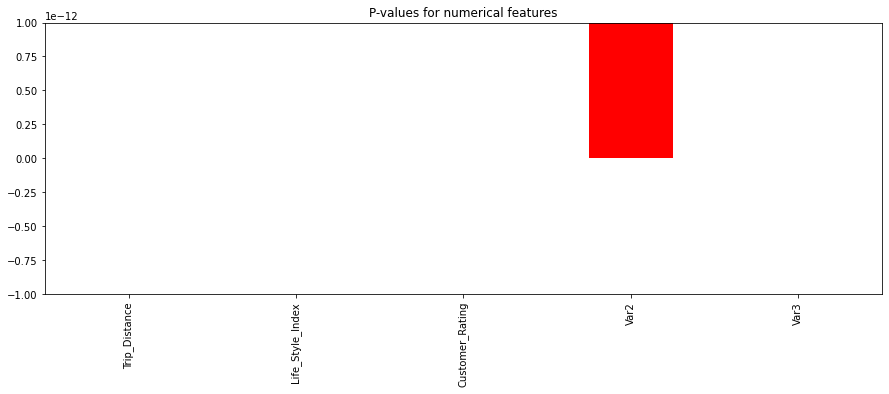

In [52]:
p_values_n.plot(kind='bar',color='r')

plt.title('P-values for numerical features')

**We can drop Variable 2 because of high p-value too.**

###**After Feature Selection we are confident with removing 4 columns:**
**1. Extra Trees Classifier - Destination_type columns**  
**2. chi2 - Gender**  
**3. ANOVA - Var2**

##**Data Preparation**

In [53]:
X=fin_df[[col for col in fin_df.columns if col not in ['Surge_Pricing_Type','Gender','Var2','Cancellation_Last_1Month','destination_type_B',
       'destination_type_C', 'destination_type_D', 'destination_type_E',
       'destination_type_F', 'destination_type_G', 'destination_type_H',
       'destination_type_I', 'destination_type_J', 'destination_type_K',
       'destination_type_L', 'destination_type_M', 'destination_type_N']]]
y=fin_df['Surge_Pricing_Type']

* **Lets split the data into train and test data**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [55]:
X_train.shape,X_test.shape

((67539, 11), (22513, 11))

**Scaling the dataset**

In [56]:
from sklearn.preprocessing import StandardScaler
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#**Implementation of models on our dataset:**

We can implement
* **Logistic Regression**
* **SVM classifier**
* **Random Forrest Classifier**
* **XGBoost Classifier**

In [57]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

##**Logistic Regression**

In [58]:
from sklearn.linear_model import LogisticRegression as LR
lr_model=LR(solver='sag',multi_class='ovr')
lr_model.fit(X_train,y_train)

LogisticRegression(multi_class='ovr', solver='sag')

In [59]:
y_pred_lr=lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))

Accuracy: 71.69%


### **Le's try hyperparameter tuning using search algorithms like:**

* **GridSearchCV**
* **RandomSearchCV**
* **BayesianSearchCV**

In [60]:
lr = LR(solver='lbfgs',multi_class='ovr')
param_dict_lr = {
    'C' : [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1e-3,1e+4,1e+5,1e+6]
}

* **Applying GridSearchCV**

In [61]:
lr_grid = GridSearchCV(estimator=lr,
                       param_grid = param_dict_lr,
                       cv = 5, verbose=2, scoring='accuracy')
#fitting the model
lr_grid.fit(X_train,y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] END ............................................C=1e-06; total time=   0.4s
[CV] END ............................................C=1e-06; total time=   0.4s
[CV] END ............................................C=1e-06; total time=   0.4s
[CV] END ............................................C=1e-06; total time=   0.4s
[CV] END ............................................C=1e-06; total time=   0.4s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ...........................................C=0.0001; total time=   0.3s
[CV] END .......................................

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='ovr'),
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 0.001, 10000.0, 100000.0, 1000000.0]},
             scoring='accuracy', verbose=2)

In [62]:
#predicting the output
y_pred_tr=lr_grid.predict(X_train)
y_pred_te=lr_grid.predict(X_test)

print('Train Accuracy score : ', accuracy_score(y_train, y_pred_tr)*100)
print('Test Accuracy score : ', accuracy_score(y_test,y_pred_te)*100)
print('\n', classification_report(y_test, y_pred_te))

Train Accuracy score :  72.00432342794534
Test Accuracy score :  71.8118420468174

               precision    recall  f1-score   support

           1       0.71      0.61      0.66      4693
           2       0.70      0.83      0.76      9718
           3       0.75      0.64      0.69      8102

    accuracy                           0.72     22513
   macro avg       0.72      0.70      0.70     22513
weighted avg       0.72      0.72      0.71     22513



In [63]:
cm=confusion_matrix(y_test,y_pred_te)
cm

array([[2883, 1262,  548],
       [ 420, 8065, 1233],
       [ 741, 2142, 5219]])

* Printing best parameters after tuning

In [64]:
print(lr_grid.best_params_)

{'C': 0.001}


* **Applying RandomSearchCV**

In [65]:
lr_random = RandomizedSearchCV(estimator=lr,
                       param_distributions = param_dict_lr,
                       cv = 5, verbose=2)

lr_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END ............................................C=1e-05; total time=   0.3s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END ............................................C=0.001; total time=   0.4s
[CV] END .......................................

RandomizedSearchCV(cv=5, estimator=LogisticRegression(multi_class='ovr'),
                   param_distributions={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                              0.1, 1, 10, 100, 0.001, 10000.0,
                                              100000.0, 1000000.0]},
                   verbose=2)

In [66]:
y_pred_tr=lr_random.predict(X_train)
y_pred_te=lr_random.predict(X_test)
print('Train Accuracy score : ', accuracy_score(y_train, y_pred_tr)*100)
print('Test Accuracy score : ', accuracy_score(y_test,y_pred_te)*100)
print('\n', classification_report(y_test, y_pred_te))

Train Accuracy score :  72.00432342794534
Test Accuracy score :  71.8118420468174

               precision    recall  f1-score   support

           1       0.71      0.61      0.66      4693
           2       0.70      0.83      0.76      9718
           3       0.75      0.64      0.69      8102

    accuracy                           0.72     22513
   macro avg       0.72      0.70      0.70     22513
weighted avg       0.72      0.72      0.71     22513



In [67]:
cm=confusion_matrix(y_test,y_pred_te)
cm

array([[2883, 1262,  548],
       [ 420, 8065, 1233],
       [ 741, 2142, 5219]])

* Printing best parameters after tuning

In [68]:
# print best parameter after tuning
print(lr_random.best_params_)

{'C': 0.001}


* **BayesianSearchCV**

In [69]:
lr_bayes = BayesSearchCV(estimator=lr,
                       search_spaces = {'C' : Real(1e-6, 1e+6, prior='log-uniform') },
                       cv = 5, verbose=2, scoring='accuracy', n_iter=32)

lr_bayes.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ................................C=8972.292669615654; total time=   0.4s
[CV] END ................................C=8972.292669615654; total time=   0.5s
[CV] END ................................C=8972.292669615654; total time=   0.4s
[CV] END ................................C=8972.292669615654; total time=   0.4s
[CV] END ................................C=8972.292669615654; total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..............................C=0.07895874329128637; total time=   0.4s
[CV] END ..............................C=0.07895874329128637; total time=   0.4s
[CV] END ..............................C=0.07895874329128637; total time=   0.4s
[CV] END ..............................C=0.07895874329128637; total time=   0.4s
[CV] END ..............................C=0.07895874329128637; total time=   0.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....

BayesSearchCV(cv=5, estimator=LogisticRegression(multi_class='ovr'), n_iter=32,
              scoring='accuracy',
              search_spaces={'C': Real(low=1e-06, high=1000000.0, prior='log-uniform', transform='normalize')},
              verbose=2)

In [70]:
y_pred_tr=lr_bayes.predict(X_train)
y_pred_te=lr_bayes.predict(X_test)
print('Train Accuracy score : ', accuracy_score(y_train, y_pred_tr)*100)
print('Test Accuracy score : ', accuracy_score(y_test,y_pred_te)*100)
print('\n', classification_report(y_test, y_pred_te))

Train Accuracy score :  71.99395904588461
Test Accuracy score :  71.80295829076535

               precision    recall  f1-score   support

           1       0.71      0.61      0.66      4693
           2       0.70      0.83      0.76      9718
           3       0.75      0.64      0.69      8102

    accuracy                           0.72     22513
   macro avg       0.72      0.70      0.70     22513
weighted avg       0.72      0.72      0.71     22513



In [71]:
cm=confusion_matrix(y_test,y_pred_te)
cm

array([[2886, 1262,  545],
       [ 421, 8064, 1233],
       [ 747, 2140, 5215]])

* Printing best parameters after tuning

In [72]:
# print best parameter after tuning
print(lr_bayes.best_params_)

OrderedDict([('C', 0.0010564035584720746)])


##**Let's apply SVM Multiclass Classification**

In [73]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier

**1. Using Linear Kernel**

In [74]:
svm_model_linear = svm.SVC(kernel = 'linear', C = 1,decision_function_shape='ovo')
svm_model_linear.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', kernel='linear')

In [75]:
linear_pred = svm_model_linear.predict(X_test)

**Evaluation metrics of linear_svm_model**

In [76]:
#checking the accuracy of linear_svm_model
linear_accuracy = accuracy_score(y_test, linear_pred)
linear_f1 = f1_score(y_test, linear_pred, average='weighted')
print('Accuracy (Linear Kernel): ', "%.2f" % (linear_accuracy*100))
print('F1 (Linear Kernel): ', "%.2f" % (linear_f1*100))

Accuracy (Linear Kernel):  71.40
F1 (Linear Kernel):  70.91


**2. Using RBF kernel**

In [77]:
svm_model_rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1,decision_function_shape='ovo')
svm_model_rbf.fit(X_train, y_train)

SVC(C=0.1, decision_function_shape='ovo', gamma=0.5)

In [78]:
rbf_pred = svm_model_rbf.predict(X_test)

**Evaluation metrics of rbf_svm_model**

In [79]:
#checking the accuracy of rbf_svm_model
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100)) 

Accuracy (RBF Kernel):  72.16
F1 (RBF Kernel):  71.88


**3. Using Poly Kernel**

In [80]:
svm_model_poly = svm.SVC(kernel='poly', degree=3, C=1,decision_function_shape='ovo')
svm_model_poly.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', kernel='poly')

In [81]:
poly_pred=svm_model_poly.predict(X_test)

**Evaluation metrics of poly_svm_model**

In [82]:
cm=confusion_matrix(y_test,poly_pred)
print(cm)

[[2866 1249  578]
 [ 421 7907 1390]
 [ 697 1965 5440]]


In [83]:
#checking the accuracy of poly_svm_model
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Poly Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Poly Kernel): ', "%.2f" % (poly_f1*100))
print('\n', classification_report(y_test, poly_pred))

Accuracy (Poly Kernel):  72.02
F1 (Poly Kernel):  71.77

               precision    recall  f1-score   support

           1       0.72      0.61      0.66      4693
           2       0.71      0.81      0.76      9718
           3       0.73      0.67      0.70      8102

    accuracy                           0.72     22513
   macro avg       0.72      0.70      0.71     22513
weighted avg       0.72      0.72      0.72     22513



In [84]:
#checking the accuracy of poly_svm_model
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Poly Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Poly Kernel): ', "%.2f" % (poly_f1*100))
print('\n', classification_report(y_test, poly_pred)) 

Accuracy (Poly Kernel):  72.02
F1 (Poly Kernel):  71.77

               precision    recall  f1-score   support

           1       0.72      0.61      0.66      4693
           2       0.71      0.81      0.76      9718
           3       0.73      0.67      0.70      8102

    accuracy                           0.72     22513
   macro avg       0.72      0.70      0.71     22513
weighted avg       0.72      0.72      0.72     22513



##**Random Forest Classifier**

In [85]:
classifier = RandomForestClassifier(n_estimators = 10,max_depth=8, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=10,
                       random_state=42)

In [86]:
#accuracy of train data
y_pred_train = classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.7272242704215343

In [87]:
#accuracy of test data
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.719495402656243

**The train and test accuracy of this random forset model is in the same range. So there is no chance of overfitting.**

###**Let's try some hyperparameter tuning in Random Forest Classifier model**

In [88]:
rf = RandomForestClassifier()

In [89]:
param_dict_rf = {
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [40, 50],
    'min_samples_split': [50, 100, 150],
    'n_estimators': [50, 80, 100]
  }

* **Applying Gridsearch cv**

In [90]:
rf_grid = GridSearchCV(estimator=rf,
                       param_grid = param_dict_rf,
                       cv = 5, verbose=3, scoring='accuracy')

rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.708 total time=   1.6s
[CV 2/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.706 total time=   1.7s
[CV 3/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.708 total time=   1.7s
[CV 4/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.703 total time=   1.7s
[CV 5/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.707 total time=   1.7s
[CV 1/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80;, score=0.708 total time=   2.6s
[CV 2/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80;, score=0.706 total time=   2.5s
[CV 3/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80;, score=0.705 total time=  

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             scoring='accuracy', verbose=3)

In [91]:
rf_grid.best_params_

{'max_depth': 8,
 'min_samples_leaf': 50,
 'min_samples_split': 100,
 'n_estimators': 100}

* **Validation of the model**

In [92]:
y_pred_tr=rf_grid.predict(X_train)
y_pred_te=rf_grid.predict(X_test)
print('Train Accuracy score : ', accuracy_score(y_train, y_pred_tr)*100)
print('Test Accuracy score : ', accuracy_score(y_test,y_pred_te)*100)
print('\n', classification_report(y_test, y_pred_te))

Train Accuracy score :  72.68245013991915
Test Accuracy score :  72.23382045929019

               precision    recall  f1-score   support

           1       0.73      0.60      0.66      4693
           2       0.71      0.83      0.76      9718
           3       0.74      0.66      0.70      8102

    accuracy                           0.72     22513
   macro avg       0.73      0.70      0.71     22513
weighted avg       0.72      0.72      0.72     22513



**The train and test accuracy are in the same range. So, there is no chance of overfitting.**

* **Applying RandomSearch CV**

In [93]:
rf_random = RandomizedSearchCV(estimator=rf,
                       param_distributions = param_dict_rf,
                       cv = 5, verbose=2, scoring='accuracy')

rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   2.6s
[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   2.6s
[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   2.6s
[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   2.6s
[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   2.6s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   2.8s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   5.2s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   5.1s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   4.7s
[CV] END max_depth=8,

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [4, 6, 8],
                                        'min_samples_leaf': [40, 50],
                                        'min_samples_split': [50, 100, 150],
                                        'n_estimators': [50, 80, 100]},
                   scoring='accuracy', verbose=2)

In [94]:
rf_random.best_params_

{'max_depth': 8,
 'min_samples_leaf': 40,
 'min_samples_split': 100,
 'n_estimators': 100}

* **Validation of the model**

In [95]:
y_pred_tr=rf_random.predict(X_train)
y_pred_te=rf_random.predict(X_test)
print('Train Accuracy score : ', accuracy_score(y_train, y_pred_tr)*100)
print('Test Accuracy score : ', accuracy_score(y_test,y_pred_te)*100)
print('\n', classification_report(y_test, y_pred_te))

Train Accuracy score :  72.66616325382371
Test Accuracy score :  72.22937858126416

               precision    recall  f1-score   support

           1       0.73      0.60      0.66      4693
           2       0.71      0.83      0.76      9718
           3       0.74      0.66      0.70      8102

    accuracy                           0.72     22513
   macro avg       0.73      0.70      0.71     22513
weighted avg       0.72      0.72      0.72     22513



**The train and test accuracy is in the same range.**

* **BayesianSearchCV**

In [96]:
rf_bayes = BayesSearchCV(estimator=rf,
                       search_spaces = {
                          'max_depth': Integer(4,8),
                          'min_samples_leaf': Integer(10,100),
                          'min_samples_split': Integer(50,150),
                          'n_estimators': Integer(10,100)
                        },
                       cv = 5, verbose=2, scoring='accuracy')

rf_bayes.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=7, min_samples_leaf=75, min_samples_split=82, n_estimators=13; total time=   0.6s
[CV] END max_depth=7, min_samples_leaf=75, min_samples_split=82, n_estimators=13; total time=   0.7s
[CV] END max_depth=7, min_samples_leaf=75, min_samples_split=82, n_estimators=13; total time=   0.8s
[CV] END max_depth=7, min_samples_leaf=75, min_samples_split=82, n_estimators=13; total time=   1.1s
[CV] END max_depth=7, min_samples_leaf=75, min_samples_split=82, n_estimators=13; total time=   1.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=7, min_samples_leaf=15, min_samples_split=113, n_estimators=14; total time=   0.7s
[CV] END max_depth=7, min_samples_leaf=15, min_samples_split=113, n_estimators=14; total time=   0.7s
[CV] END max_depth=7, min_samples_leaf=15, min_samples_split=113, n_estimators=14; total time=   0.7s
[CV] END max_depth=7, min_samples_leaf=15, min_samples_split=113, n_est

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), scoring='accuracy',
              search_spaces={'max_depth': Integer(low=4, high=8, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=50, high=150, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=100, prior='uniform', transform='normalize')},
              verbose=2)

In [97]:
rf_bayes.best_params_

OrderedDict([('max_depth', 8),
             ('min_samples_leaf', 49),
             ('min_samples_split', 109),
             ('n_estimators', 21)])

In [98]:
y_pred_tr=rf_bayes.predict(X_train)
y_pred_te=rf_bayes.predict(X_test)
print('Train Accuracy score : ', accuracy_score(y_train, y_pred_tr)*100)
print('Test Accuracy score : ', accuracy_score(y_test,y_pred_te)*100)
print('\n', classification_report(y_test, y_pred_te))

cm=confusion_matrix(y_test,y_pred_te)
cm

Train Accuracy score :  72.68837264395387
Test Accuracy score :  72.2826811175765

               precision    recall  f1-score   support

           1       0.72      0.61      0.66      4693
           2       0.71      0.82      0.76      9718
           3       0.74      0.66      0.70      8102

    accuracy                           0.72     22513
   macro avg       0.72      0.70      0.71     22513
weighted avg       0.72      0.72      0.72     22513



array([[2873, 1256,  564],
       [ 417, 8015, 1286],
       [ 707, 2010, 5385]])

##**XGBoost Classifier**

In [99]:
xgb_model = XGBClassifier(probability=True,random_state=0)
xgb_model.fit(X_train,y_train)

XGBClassifier(objective='multi:softprob', probability=True)

* **Validation of the model**

**Now, we have fitted our data on Xgboost model. As it is a tree based model, hence there is a chance of overfitting.**

**So, let's validate it by printing accuracy on train and test set.**

In [100]:
xgb_y_predict_tr = xgb_model.predict(X_train)
xgb_y_predict_te = xgb_model.predict(X_test)

xgb_accuracy_tr = accuracy_score(y_train, xgb_y_predict_tr)
print(f'Train accuracy is: {xgb_accuracy_tr*100}')

xgb_accuracy_te = accuracy_score(y_test, xgb_y_predict_te)
print(f'Test accuracy is: {xgb_accuracy_te*100}')


Train accuracy is: 72.58472882334651
Test accuracy is: 72.33154177586285


In [101]:
print('\n', classification_report(y_test, xgb_y_predict_te))

cm=confusion_matrix(y_test,xgb_y_predict_te)
cm


               precision    recall  f1-score   support

           1       0.73      0.61      0.67      4693
           2       0.71      0.82      0.76      9718
           3       0.74      0.67      0.71      8102

    accuracy                           0.72     22513
   macro avg       0.73      0.70      0.71     22513
weighted avg       0.72      0.72      0.72     22513



array([[2880, 1253,  560],
       [ 415, 7951, 1352],
       [ 668, 1981, 5453]])

##**Conclusion**
**Started with loading the data so far we have done EDA , null values treatment, encoding of categorical columns, feature selection and then model building.**

**Modeled on:** 
* Logistic Regression
* SVM Classifier
* Random Forest Classifier
* XGBoost classifier


###In all of these models my accuracy revolves in the range of 70 to 73%. 
**There is no such improvement in accuracy score even after hyperparameter tuning.**

**So the accuracy of best model is 73% which can be said to be good for this large dataset.**